## 影響山崩發生之因素分析

我們將使用Kaggle平台上的[Landslide Risk Assessment Factors](https://www.kaggle.com/datasets/mohammadrahdanmofrad/landslide-risk-assessment-factors)資料集及其他相關資料進行分析

In [1]:
!mkdir -p data
!curl -L -o ./landslides-risk-assessment-factors.zip \
    https://www.kaggle.com/api/v1/datasets/download/mohammadrahdanmofrad/landslide-risk-assessment-factors
!unzip -n ./landslides-risk-assessment-factors.zip -d ./data
!rm ./landslides-risk-assessment-factors.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  183k  100  183k    0     0   100k      0  0:00:01  0:00:01 --:--:--  166k
Archive:  ./landslides-risk-assessment-factors.zip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

In [2]:
landslide_factors_df = pd.read_csv('./data/Landslide_Factors_IRAN.csv')
landslide_factors_df.head()

,ID,LONG,LAT,SUB_Basin,Elevation,AAP(mm),RiverDIST(m),FaultDIST(m),Landuse_Type,Slop(Percent),Slop(Degrees),GEO_UNIT,DES_GEOUNI,Climate_Type,DES_ClimateType
0,1,52.326,27.763,Mehran,617.0,137,1448.705292,40639.57890,poorrange,42.240669,22.899523,EOas-ja,"Undivided Asmari and Jahrum Formation , regard...",A-M-VW,"Warm and humid, with a humid period longer tha..."
1,2,52.333,27.772,Mehran,944.0,137,344.299484,40135.02913,mix(woodland_x),68.219116,34.301464,KEpd-gu,Keewatin Epedotic quartz diorite,A-M-VW,"Warm and humid, with a humid period longer tha..."
2,3,52.326,27.763,Mehran,617.0,137,1448.705292,40639.57890,poorrange,42.240669,22.899523,EOas-ja,"Undivided Asmari and Jahrum Formation , regard...",A-M-VW,"Warm and humid, with a humid period longer tha..."
3,4,52.333,27.694,Mehran,55.0,137,1889.828623,42189.54442,rock,12.141766,6.922833,Mlmmi,Low weathering grey marls alternating with ba...,A-M-VW,"Warm and humid, with a humid period longer tha..."
4,5,52.324,27.682,Mehran,20.0,137,874.201691,43010.08400,poorrange,2.216230,1.269598,MuPlaj,"Brown to grey , calcareous , feature - formin...",A-M-VW,"Warm and humid, with a humid period longer tha..."


In [3]:
landslide_factors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4295 entries, 0 to 4294
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               4295 non-null   int64  
 1   LONG             4295 non-null   float64
 2   LAT              4295 non-null   float64
 3   SUB_Basin        4295 non-null   object 
 4   Elevation        4295 non-null   float64
 5   AAP(mm)          4295 non-null   int64  
 6   RiverDIST(m)     4295 non-null   float64
 7   FaultDIST(m)     4295 non-null   float64
 8   Landuse_Type     4295 non-null   object 
 9   Slop(Percent)    4295 non-null   float64
 10  Slop(Degrees)    4295 non-null   float64
 11  GEO_UNIT         4295 non-null   object 
 12  DES_GEOUNI       4295 non-null   object 
 13  Climate_Type     4295 non-null   object 
 14  DES_ClimateType  4295 non-null   object 
dtypes: float64(7), int64(2), object(6)
memory usage: 503.4+ KB


In [4]:
landslide_factors_df.isna().sum()

ID                 0
LONG               0
LAT                0
SUB_Basin          0
Elevation          0
AAP(mm)            0
RiverDIST(m)       0
FaultDIST(m)       0
Landuse_Type       0
Slop(Percent)      0
Slop(Degrees)      0
GEO_UNIT           0
DES_GEOUNI         0
Climate_Type       0
DES_ClimateType    0
dtype: int64

In [5]:
landslide_factors_df.duplicated().sum()

np.int64(0)

## 基於地理分佈以及地理特徵進行分析

這個區塊將著重分析以下特徵：
* SUB_Basin - 流域
* Elevation - 海拔
* RiverDIST(m) - 與河流的距離
* FaultDIST(m) - 與斷層的距離
* Slop(Degrees) - 坡度

藉由經緯度將山崩發生點標記在地圖上，觀察其地理上的分佈。再透過統計值和圖表呈現特徵值的分佈、特徵間的關聯性。分析同一地域內的山崩發生點有何共通性質，並進一步挖掘這些性質是否具有跨地域的普遍性。

In [6]:
landslide_factors_df.describe(include=[object])

,SUB_Basin,Landuse_Type,GEO_UNIT,DES_GEOUNI,Climate_Type,DES_ClimateType
count,4295,4295,4295,4295,4295,4295
unique,65,37,217,204,15,5
top,Karun,modrange,Qft2,Low level piedmont fan and valley teraces dep...,SA-K-W,"Hot and dry, with a dry period longer than the..."
freq,593,602,331,331,1492,3622


In [7]:
# 資料筆數為4,295筆
# 流域計數65個
n = 5 # 取n個流域

basin_df = landslide_factors_df.groupby(['SUB_Basin'])
top = basin_df.count().sort_values(by=['ID'], ascending=False).iloc[:n] # 依資料筆數排序，取前n個
top.index

Index(['Karun', 'Qezel Owzan', 'Gorgan', 'Diyala', 'Safid Rud'], dtype='object', name='SUB_Basin')

In [8]:
selected_basin = landslide_factors_df.loc[landslide_factors_df['SUB_Basin'].isin(top.index)]

In [9]:
coordinate = gpd.points_from_xy(selected_basin.LONG, selected_basin.LAT)
basin_geometry = gpd.GeoDataFrame(selected_basin, crs='EPSG:4326', geometry=coordinate)

In [10]:
basin_geometry.explore(
    column='SUB_Basin',
    tooltip='Elevation',
    tiles='CartoDB positron',
    cmap='tab10',
    marker_kwds=dict(
        radius=4,
    ),
    style_kwds=dict(
        color='white',
        weight=1
    )
)

In [11]:
selected_basin.groupby(['SUB_Basin'])['Slop(Degrees)'].describe().transpose()

SUB_Basin,Diyala,Gorgan,Karun,Qezel Owzan,Safid Rud
count,279.000000,364.000000,593.000000,447.000000,184.000000
mean,14.314067,12.008376,15.000267,13.685941,8.646052
std,8.359985,7.486296,7.866145,7.214447,5.152329
min,0.243473,0.020995,0.662292,0.392584,0.243473
25%,8.186776,6.338880,8.830061,8.152231,4.864146
50%,13.158305,10.952727,14.322357,12.426897,7.800995
75%,19.564451,16.124086,20.249668,18.300032,12.057580
max,44.542999,35.010189,36.279507,35.514732,28.683409


<Axes: xlabel='SUB_Basin', ylabel='Slop(Degrees)'>

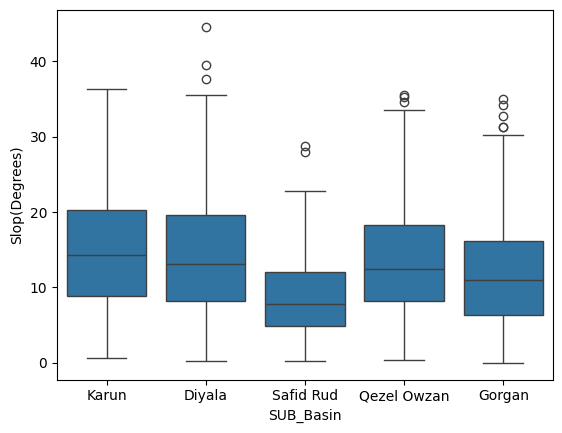

In [12]:
sns.boxplot(selected_basin, x='SUB_Basin', y='Slop(Degrees)')

In [13]:
landslide_factors_df[['Slop(Degrees)']].describe()

,Slop(Degrees)
count,4295.000000
mean,12.684708
std,7.976655
min,0.000000
25%,6.579355
50%,11.540784
75%,17.432177
max,45.000000


<Axes: ylabel='Slop(Degrees)'>

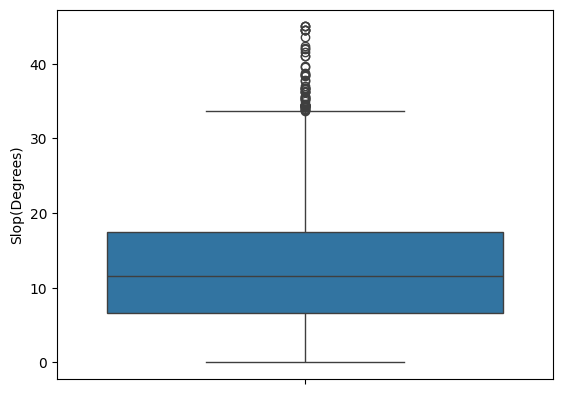

In [14]:
sns.boxplot(landslide_factors_df['Slop(Degrees)'])

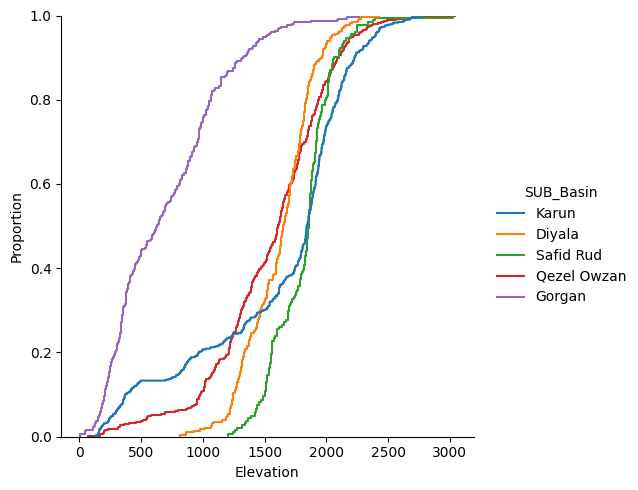

In [15]:
sns.displot(selected_basin, x='Elevation', hue='SUB_Basin', kind='ecdf')

In [16]:
landslide_factors_df[['RiverDIST(m)', 'FaultDIST(m)']].describe()

,RiverDIST(m),FaultDIST(m)
count,4295.000000,4295.000000
mean,809.247705,5464.176909
std,974.939030,5920.570823
min,0.065920,1.121601
25%,208.199375,1314.589467
50%,526.187336,3486.626632
75%,1116.083961,7701.447471
max,25656.226180,44108.087060


<Axes: xlabel='RiverDIST(m)', ylabel='Count'>

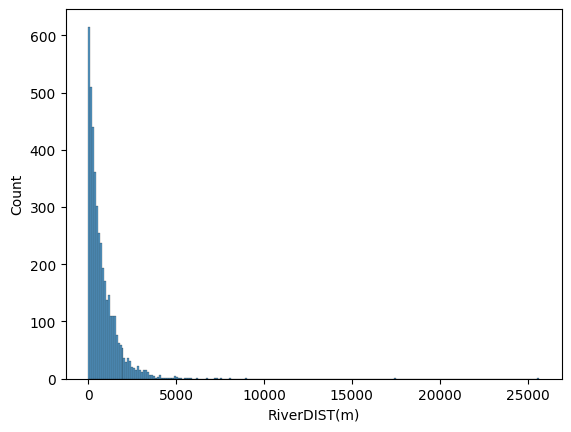

In [17]:
sns.histplot(landslide_factors_df, x='RiverDIST(m)')

<Axes: xlabel='FaultDIST(m)', ylabel='Count'>

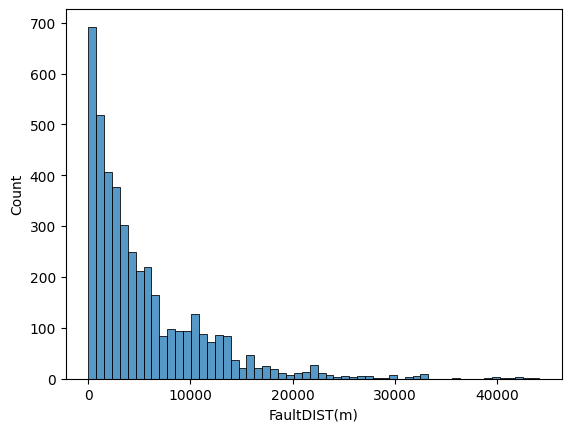

In [18]:
sns.histplot(landslide_factors_df, x='FaultDIST(m)')

## 氣候因素對山崩發生的影響分析

In [19]:
landslide_factors_df[['AAP(mm)']].describe()

,AAP(mm)
count,4295.000000
mean,242.166007
std,136.964710
min,54.000000
25%,158.000000
50%,194.000000
75%,270.000000
max,1142.000000


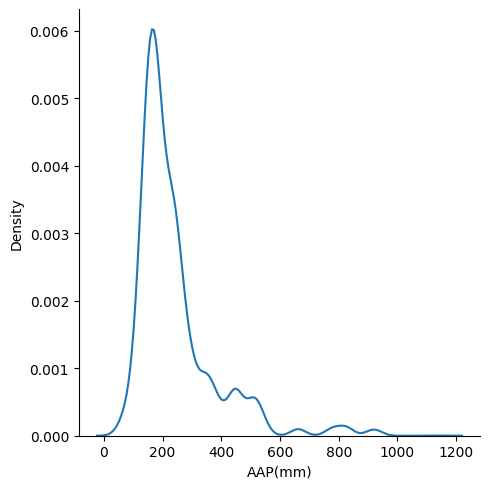

In [20]:
sns.displot(landslide_factors_df['AAP(mm)'], kind='kde')

## 特徵關聯分析

使用統計方法和演算法進行特徵關聯分析
* Chi-Square test

    * Refer to [Correlation between Categorical Variables](https://medium.com/@ritesh.110587/correlation-between-categorical-variables-63f6bd9bf2f7)
* Pearson correlation coeffcient
* Apriori algoithm

In [21]:
col = landslide_factors_df.select_dtypes(include=[object]).drop(['DES_GEOUNI', 'DES_ClimateType'], axis=1).columns
df_cat = landslide_factors_df[col]
df_cat.head()

,SUB_Basin,Landuse_Type,GEO_UNIT,Climate_Type
0,Mehran,poorrange,EOas-ja,A-M-VW
1,Mehran,mix(woodland_x),KEpd-gu,A-M-VW
2,Mehran,poorrange,EOas-ja,A-M-VW
3,Mehran,rock,Mlmmi,A-M-VW
4,Mehran,poorrange,MuPlaj,A-M-VW


In [22]:
# 抽樣方法、樣本數量須再做調整
sample_df = df_cat.groupby(['SUB_Basin']).sample(frac=0.01)
sample_df.shape

(39, 4)

In [23]:
from itertools import product
import scipy.stats as ss

var1 = col.to_list()
var2 = var1

var_prod = list(product(var1, var2))
tmp = []
for i in var_prod:
    if i[0] != i[1]:
        res = ss.chi2_contingency(pd.crosstab(sample_df[i[0]], sample_df[i[1]]))
        tmp.append((i[0], i[1], res.pvalue))
tmp

[('SUB_Basin', 'Landuse_Type', np.float64(0.30494184732740454)),
 ('SUB_Basin', 'GEO_UNIT', np.float64(0.048689577923336905)),
 ('SUB_Basin', 'Climate_Type', np.float64(0.054130019130282675)),
 ('Landuse_Type', 'SUB_Basin', np.float64(0.30494184732740454)),
 ('Landuse_Type', 'GEO_UNIT', np.float64(0.9741832896075227)),
 ('Landuse_Type', 'Climate_Type', np.float64(0.40989974464597884)),
 ('GEO_UNIT', 'SUB_Basin', np.float64(0.04868957792333658)),
 ('GEO_UNIT', 'Landuse_Type', np.float64(0.9741832896075227)),
 ('GEO_UNIT', 'Climate_Type', np.float64(0.006870687577754913)),
 ('Climate_Type', 'SUB_Basin', np.float64(0.05413001913028282)),
 ('Climate_Type', 'Landuse_Type', np.float64(0.4098997446459796)),
 ('Climate_Type', 'GEO_UNIT', np.float64(0.006870687577754933))]

In [24]:
chi_test = pd.DataFrame(tmp, columns=['var1', 'var2', 'coeff'])
chi_test_pivot = chi_test.pivot(index='var1', columns='var2', values='coeff')
chi_test_pivot

var2,Climate_Type,GEO_UNIT,Landuse_Type,SUB_Basin
var1,,,,
Climate_Type,NaN,0.006871,0.409900,0.054130
GEO_UNIT,0.006871,NaN,0.974183,0.048690
Landuse_Type,0.409900,0.974183,NaN,0.304942
SUB_Basin,0.054130,0.048690,0.304942,NaN


<Axes: xlabel='var2', ylabel='var1'>

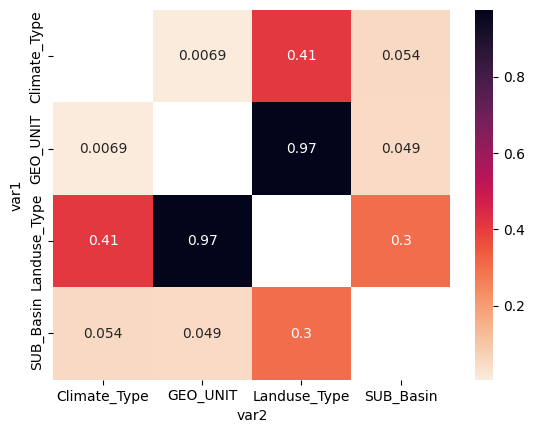

In [ ]:
sns.heatmap(chi_test_pivot, cmap='rocket_r', annot=True)

<Axes: >

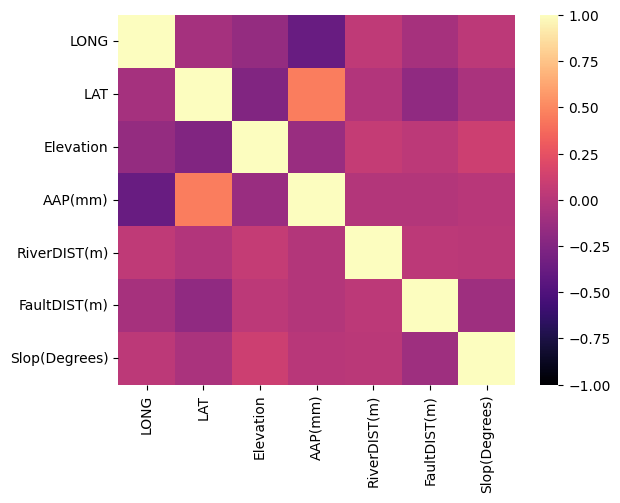

In [26]:
# Slop(Degrees)和Slop(Perecent)皆是坡度欄位，唯單位不同，兩者相關係數為1，故只取其一
corr_metrix = landslide_factors_df.drop(['ID', 'Slop(Percent)'], axis=1).corr(numeric_only=True)
sns.heatmap(corr_metrix, vmin=-1, vmax=1, cmap='magma')

觀察上圖，特徵兩兩間多無顯著的線性相依性，僅有經緯度和平均年降雨量呈較弱的關聯。
* 伊朗東部較為乾旱，故經度愈往東則降雨量愈少
* 北部比鄰裏海，降雨量較多